# Artificial Neural Networks (CS-456)
# Miniproject 1: Tic Tac Toe
- Mickaël Achkar (322190)
- Yehya El Hassan (325932)


In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from typing import Dict, List, Union, Callable, Tuple
import hashlib
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from random import randrange
import seaborn as sns
from collections import deque
import torch.nn as nn
import torch
from torch.nn import functional as F
from torch import tensor
import torch.optim as optim

np.random.seed(0)

Utility functions used for both Approaches (DQN and Tabular Q-learning).

We implemented a set of utility functions that will be used in the RL training procedure. Specifically:

1. A `logger` function that prints the outcome of the game. 
2. A `choose_players` function that will be used to switch the first player to start to play at every episode.
3. A `plot_rewards` function that plot the averaged rewards in a default window of $250$ games.    
4. A `plot_metrics` function that plot the $M_{opt}$ (optimal metric) and the $M_{rand}$ (random metric).
5. A `plot_epsilon` function that plot the evolution of epsilon with number of episodes for number of exploratory games.
6. A `plot_loss` function that plot the average training loss of the DQN Network with number of episodes.  

In [2]:
def logger(winner, player_1, player_2):
    # Logs the information if specified
    print('-------------------------------------------')
    print(f'Game end, winner is player {str(winner)}')
    print(f'Optimal player 1 = {str(player_1)}')
    print(f'RL Agent player 2 = {str(player_2)}')
    
def choose_players(index):
    if index%2 == 0:
        player_1 = 'X'
        player_2 = 'O'
    else:
        player_1 = 'O'
        player_2 = 'X' 
        
    return player_1,player_2 

def plot_rewards(number_of_episodes, rewards, ax, label = "", plot_every=250):
    episodes = np.arange(0,number_of_episodes)
    bin_means, _, _ = binned_statistic(episodes, rewards, statistic="mean", bins =(number_of_episodes)/plot_every, range=(0, number_of_episodes))
    ax.plot(np.arange(0, number_of_episodes, plot_every), bin_means, label = label)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.legend()
    return

def plot_metrics(number_of_episodes, metrics, ax, label):
    ax.plot(np.arange(0, number_of_episodes, 250), metrics, label = label)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Metric")
    ax.legend()
    return

def plot_epsilon(number_of_episodes, epsilon_list, ax, label):
    ax.plot(range(number_of_episodes), epsilon_list, label = label)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Epsilon")
    ax.legend()
    return

def plot_loss(number_of_episodes, loss, ax, label = "", plot_every=250):
    ax.plot(np.arange(0, number_of_episodes, plot_every), loss, label = label)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Loss")
    ax.legend()
    return    

## Tabular Q-Learning
In order to implement an agent that utilizes reinforecement learning to play Tic Tac Toe, we implemented an RLAgent class. This class handles all the needed functionalities of the RL agent such as:

* `observe_state` which stores the game board and updates the list of possible actions.
* `get_epsilon` which returns the value of epsilon. Epsilon can be either fixed or monotonically decreasing as discussed later.
* `update_nb_of_episode_played` which updates the number of episodes played to calculate the value of the monotonically decreasing epsilon.
* `observe_reward` which updates the internal stored value of the reward given by the environment.
* `act` which selects an action from a list of possibled actions based on $\epsilon$-greedy strategy.
* `update_q_table` which stores and updates a table that contains a $Q$-value for every state and action possible in the given environment.

In addition, other internal functions are denoted by a `_` prefix to implement the above discussed functionalities.

In [3]:
class RlAgent():
    def __init__(self, player: str, epsilon: Union[float, Callable], learning_rate: float = 0.05, discount_factor: float = 0.99):
        # Choose the Player (X,O)
        self.player = player

        # Choose the exploration/exploitation factor
        self.epsilon = epsilon

        # RL training hyper params
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

        # Form the the q_table and initialize it to empty
        self.q_table: Dict[str,np.ndarray] = {}

        # Store all observed states for heat map generation
        self.observed_states: List[np.ndarray] = []

        # Actions take values between 0 and 9 representing the possible positions on the board
        self.list_of_possible_actions: List[int] = [] 

        # Update current episode number
        self.current_episode = 0

        # Update the is_test flag
        self.is_test = False
    
    def test(self):
        # set to testing behavior
        self.is_test = True
    
    def train(self):
        # set to training behavior
        self.is_test = False

    def observe_state(self, board, store_state:bool = False):
        # Observe the current state of the environment
        if store_state:
            self.observed_states.append(board)
        self._update_board(board)
        self._update_list_of_possible_actions()


    def update_nb_of_episode_played(self, episode_number):
        self.current_episode = episode_number

    def get_epsilon(self):
        # Retun the current epsilon
        if (isinstance(self.epsilon, Callable)):
            return self.epsilon(self.current_episode)
        else:
            return self.epsilon

    def act(self, board: np.ndarray):
        # TODO: check if passing the board is needed.
        current_state = self.get_state_key(board)

        if (not self.is_test):
            # Sample from a uniform distribution
            if (random.uniform(0,1)<self.get_epsilon()):
                return self._choose_random_action()
            else:
                return self._choose_best_action(current_state)
        else:
            return self._choose_best_action(current_state)

    def update_q_table(self, current_board_config, current_action, current_reward, next_board_config, terminal_state = False):
        # update the q_table
        current_state = self.get_state_key(current_board_config)
        next_state = self.get_state_key(next_board_config)

        # create new entries if needed
        self._create_new_state_entries_if_needed(current_state)
        self._create_new_state_entries_if_needed(next_state)

        if not terminal_state:
            best_action = self._choose_best_action(next_state)
            self.q_table[current_state][current_action] = self.q_table[current_state][current_action] + self.learning_rate*(current_reward + self.discount_factor*(self.q_table[next_state][best_action]) - self.q_table[current_state][current_action])
        else:
            self.q_table[current_state][current_action] = self.q_table[current_state][current_action] + self.learning_rate*(current_reward - self.q_table[current_state][current_action])

    def _update_board(self, board):
        # Get's the latest board configuration from the Game
        self.board = board
    
    def _update_list_of_possible_actions(self):
        # Get's the available positions on the board
        available_actions = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if self.board[pos] == 0:
                available_actions.append(i)
        self.list_of_possible_actions = available_actions
        return self.list_of_possible_actions

    def _choose_best_action(self, current_state):
        self._create_new_state_entries_if_needed(current_state)
        maximum_q_values_idx = np.where(self.q_table[current_state][self.list_of_possible_actions] == np.max(self.q_table[current_state][self.list_of_possible_actions]))[0]
        random_max = np.random.choice(maximum_q_values_idx)
        return (self.list_of_possible_actions[random_max])

    def _choose_random_action(self):
        return np.random.choice(self.list_of_possible_actions)

    def _create_new_state_entries_if_needed(self, state):
        if (not isinstance(self.q_table.get(state), np.ndarray)):
            self.q_table[state] = np.zeros(9)
    
    @staticmethod
    def get_state_key(board):
     # Convert the Board configuration (Matrix) into a unique key for the state
        return hashlib.sha1(board).hexdigest()


In [4]:
def convert_value_to_play_character(state: np.ndarray, q_values):
    representation: List[List[str]] = [] 
    line: List[str] = [] 
    state = state.flatten()

    for start in range(0, 9, 3):
        line = []
        for index in range(start, start+3):
            if state[index] == 0:
                line.append(f"{round(float(q_values[index]) ,3)}")
            elif state[index] == 1:
                line.append("X")
            elif state[index] == -1:
                line.append("O")
        representation.append(line)
    representation = np.array(representation)
    return representation

Now after implementing the needed functionalities of the RL agent we proceed to implementing a RL training procedure for Tic Tac Toe Player using Q-learning algorithm. With that, we will create a Q-table representing all the states and actions possible and we will progressively update the values in the table. The values in this table will depict the reward the agent expects to get if the corresponding action was chosen in the given state. In other words, if the values in the Q-table are the true values, then the optimal policy of the agent is to choose the actions whose corresponding Q-values are maximum in a given state. 

Since the Q-learning utilize current state, current action and next state Q-values, the Q-table is updated every 2 moves. With that, the Q-learning pipeline will look as follows:

Given a certain current Tic-Tac-Toe state denoted by (S):

1. RL agent choose an action (A) based on epsilon greedy and stores the chosen action. 
2. Optimal player choose an action based on the optimal level chosen.

Now the RL agent observes a different state denoted by (S')

3. RL agent choose an action (A') based on epsilon greedy and update the Q-table using the (S, A, S' and greedy action A*). A* might be different than A' as Q-learning is an-off policy strategy where A* is the action that maximize the Q-value for the given state (S').    

In [5]:
def train_rl_agent_qlearning(environment: TictactoeEnv, number_of_episodes: int, optimal_level : float, epsilon:float, test_episode:int, verbose: bool = False):
    # Initialize the Rewards and Test Metrics
    rewards = np.zeros(number_of_episodes)
    metrics_opt = np.zeros(int(number_of_episodes/test_episode))
    metrics_rand = np.zeros(int(number_of_episodes/test_episode))

    # Instantiate the Players
    player_optimal = OptimalPlayer(epsilon=optimal_level, player="X")
    player_rl_agent = RlAgent(epsilon=epsilon, player="O")

    for episode in tqdm(range(number_of_episodes)):
        player_rl_agent.train()
        
        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()

        #Choose the players X,O
        optimal_player_character,rl_player_character = choose_players(index = episode)
        player_optimal.player = optimal_player_character
        player_rl_agent.player = rl_player_character
        
        # Give RL access to the board
        player_rl_agent.observe_state(grid)

        # Update nb of episode played
        player_rl_agent.update_nb_of_episode_played(episode) 


        # store backup diagram 
        states_actions_rewards_observed: List[Tuple[np.ndarray, int, int]] = []
        
        for step in range(9):
            if environment.current_player == player_optimal.player:
                # choose an move
                move = player_optimal.act(grid)

                #Execute an action
                grid, end, winner = environment.step(move, print_grid=False)
            
            else:
                #RL current state and action
                player_rl_agent.observe_state(grid)
                rl_state = grid
                rl_action = player_rl_agent.act(grid)

                #Execute action
                move = (int(rl_action/3),rl_action%3)
                grid, end, winner = environment.step(move, print_grid=False)
                rl_reward = environment.reward(rl_player_character)
                states_actions_rewards_observed.append((rl_state,rl_action,rl_reward))

                if len(states_actions_rewards_observed)==2:
                    previous_state, previous_action, reward = states_actions_rewards_observed.pop(0)
                    player_rl_agent.update_q_table(previous_state, previous_action,reward, rl_state)

            if end:
                # observe end reward
                reward = environment.reward(rl_player_character)
                rewards[episode] = reward
                player_rl_agent.update_q_table(rl_state, rl_action, reward, grid, terminal_state=True )
        
                if verbose:
                    logger(winner, optimal_player_character, rl_player_character)
                    environment.render()
                environment.reset()
                break
        
        if ((episode)%test_episode == 0):
            m_opt, m_rand = compute_metrics(environment, player_rl_agent, 500)
            metrics_opt[int(episode/test_episode)] = m_opt
            metrics_rand[int(episode/test_episode)] = m_rand
    return player_rl_agent, rewards, metrics_opt, metrics_rand   




In order to assess the "test" performance of the RL agent, we will need to compute the M_opt and M_rand metric. The M_opt metric assesses how well the RL agent performs against the player following an optimal policy while the M_rand metric assesses how well the RL agent performs against a player playing a random policy.

With that, two functions are needed. A function that allows the RL agent to play (without updating the Q_table) against the above described players and anoother function that computes the $M_{opt}$ and $M_{rand}$ using the equation:
$ (N_{win} - N_{loss})/ N_{played} $ 

In [6]:
def compute_metrics(environment: TictactoeEnv, player_rl_agent:RlAgent, number_of_episodes:int, verbose: bool = False):
    player_rl_agent.test()
    
    number_of_rl_wins, number_of_optimal_wins = evaluate_rl_agent_qlearning(environment, player_rl_agent,number_of_episodes, 0.0, verbose)
    M_opt = (number_of_rl_wins -  number_of_optimal_wins)/number_of_episodes

    number_of_rl_wins, number_of_optimal_wins = evaluate_rl_agent_qlearning(environment, player_rl_agent,number_of_episodes, 1.0, verbose)
    M_rand = (number_of_rl_wins -  number_of_optimal_wins)/number_of_episodes

    return M_opt, M_rand

def evaluate_rl_agent_qlearning(environment: TictactoeEnv, player_rl_agent:RlAgent, number_of_episodes:int, optimal_level : float, verbose: bool = False):
    # Instantiate the Players
    player_optimal = OptimalPlayer(epsilon=optimal_level, player="X")
    player_rl_agent.player = "O"

    number_of_rl_wins = 0
    number_of_optimal_wins = 0
    for episode in range(number_of_episodes):
        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()

        #Choose the players X,O
        optimal_player_character, rl_player_character = choose_players(index = episode)
        player_optimal.player = optimal_player_character
        player_rl_agent.player = rl_player_character
        
        # Give RL access to the board
        player_rl_agent.observe_state(grid)
        
        for step in range(9):
            if environment.current_player == player_optimal.player:
                move = player_optimal.act(grid)
            else:
                player_rl_agent.observe_state(grid)
                rl_current_action = player_rl_agent.act(grid)
                move = (int(rl_current_action/3),rl_current_action%3)
        
            grid, end, winner = environment.step(move, print_grid=False)
            
            
            if end:
                if winner == optimal_player_character:
                    number_of_optimal_wins +=1
                    
                if winner == rl_player_character:
                    number_of_rl_wins += 1
                    
                if verbose:
                    logger(winner, optimal_player_character, rl_player_character)
                    environment.render()
                environment.reset()
                break
        

    return number_of_rl_wins, number_of_optimal_wins   

### Learning from experts
##### Question 1
Finally, after implementing all the needed functions, we will now explore the effects of the epsilon on training. We will start by using a fixed epsilon through the training procedure (i.e accross all the episodes) and then we will compare the training preformance with that of a monotonically decreasing epsilon throughout the training procedure.

100%|██████████| 20000/20000 [01:10<00:00, 283.16it/s]


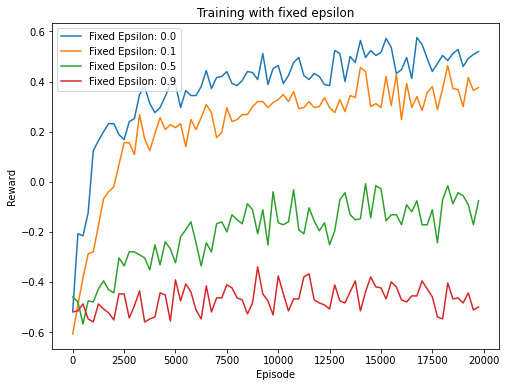

In [7]:
# Training with a fixed epsilon (Question 1)

# RL Hyper-params
number_of_episodes = 20000

# Environment
environment = TictactoeEnv()

# plots 
fig,ax = plt.subplots(figsize=(8, 6))
plt.title("Training with fixed epsilon")

# List of epsilons to try 
epsilons= [0.0, 0.1, 0.5, 0.9]

for epsilon in epsilons:
    # Train and get the rewards for a fixed epsilon 
    player_rl_agent, rewards, _, _ = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=0.5, epsilon=epsilon, test_episode=number_of_episodes)
    plot_rewards(number_of_episodes, rewards, ax, label=f"Fixed Epsilon: {epsilon}")


#### Decreasing exploration
##### Questions 2 & 3

100%|██████████| 20000/20000 [05:14<00:00, 63.61it/s] 


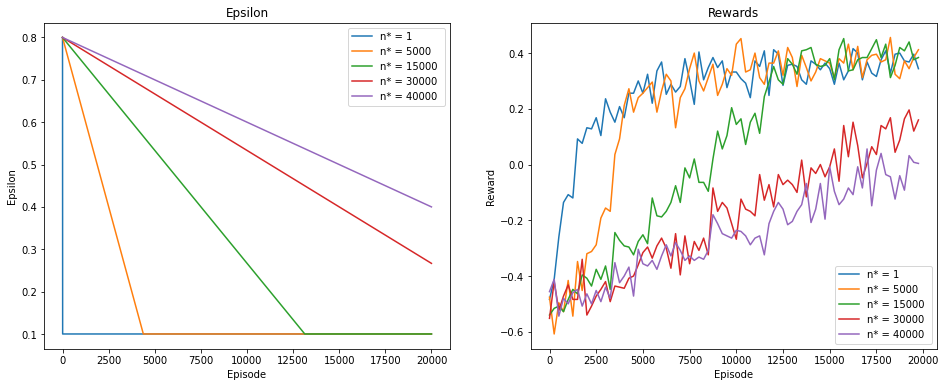

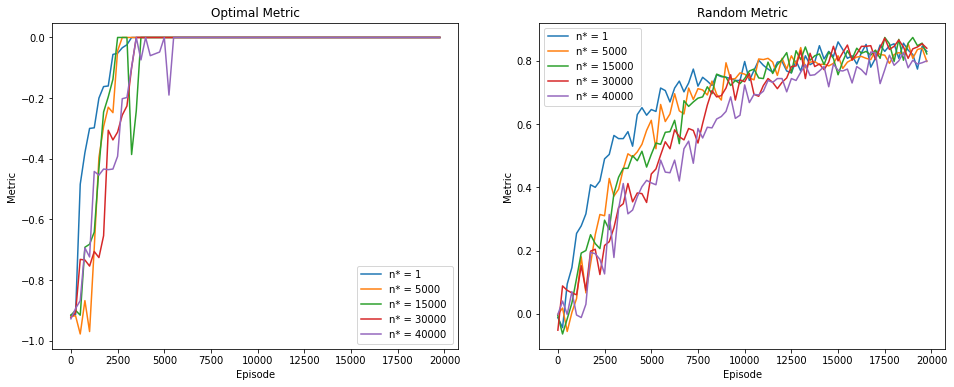

In [8]:
# Training with a monotonically decreasing epsilon (Question 2 and Question 3)

# RL Hyper-params
number_of_episodes = 20000

epsilon_min, epsilon_max = 0.1, 0.8

# Environment
environment = TictactoeEnv()

# Plots
fig1, axes1 = plt.subplots(1, 2, figsize=(16, 6))
axes1[0].set_title("Epsilon")
axes1[1].set_title("Rewards")
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
axes2[0].set_title("Optimal Metric")
axes2[1].set_title("Random Metric")

list_of_number_of_exploratory_games = [1, 5000, 15000, 30000, 40000]
 
for number_of_exploratory_games in list_of_number_of_exploratory_games:
    # Train and get the rewards, M_opt, M_rand for a decreasing monotinically epsilon 
    epsilon = lambda n: max(epsilon_min, epsilon_max*(1-(n/number_of_exploratory_games)))
    player_rl_agent, rewards, m_opt, m_rand = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=0.5, epsilon=epsilon, test_episode=250)
    epsilon_list = [epsilon(n) for n in range(number_of_episodes)]
    plot_epsilon(number_of_episodes, epsilon_list, axes1[0], label = f"n* = {number_of_exploratory_games} ")
    plot_rewards(number_of_episodes, rewards, axes1[1], label = f"n* = {number_of_exploratory_games} ")
    plot_metrics(number_of_episodes, m_opt, axes2[0], label = f"n* = {number_of_exploratory_games} ")
    plot_metrics(number_of_episodes, m_rand, axes2[1], label = f"n* = {number_of_exploratory_games} ")


#### Good experts and bad experts
##### Question 4
Now that we have explored the effect of the (fixed/varying) epsilon on the training performance, we will explore the effect of the optimality of the teacher on the training policy. Specifically, would the RL agent train better if it trained against an optimal policy or a random policy or somewhere in between?

100%|██████████| 20000/20000 [04:26<00:00, 75.03it/s] 


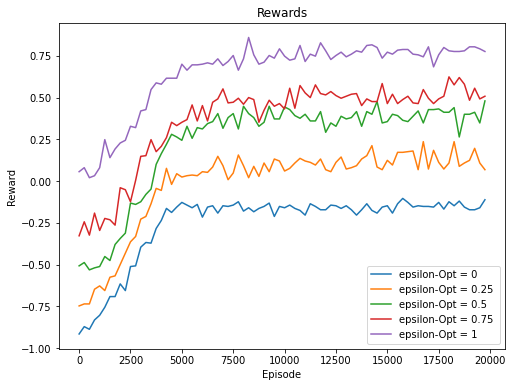

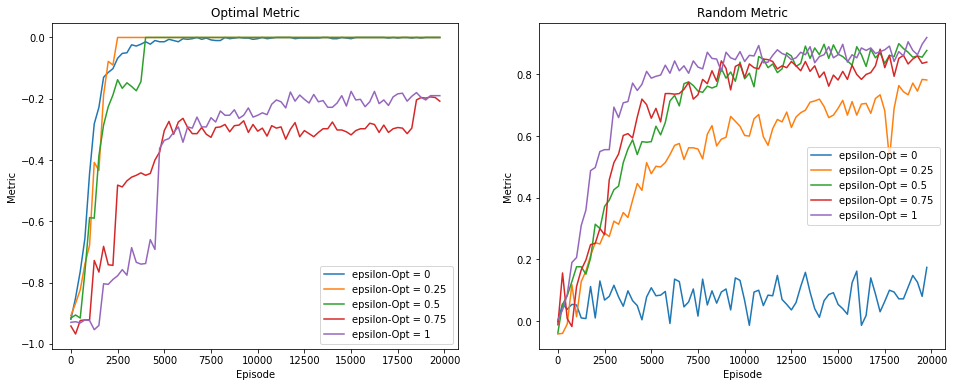

In [13]:
# Train with various Optimal level of the Agent for the optimal n* = 5000 (Question 4). 

# RL Hyper-params
number_of_episodes = 20000
epsilon_min,epsilon_max = 0.1, 0.8
number_of_exploratory_games = 5000
epsilon = lambda n: max(epsilon_min, epsilon_max*(1-(n/number_of_exploratory_games)))

# Environment
environment = TictactoeEnv()

# Plot
fig,ax = plt.subplots(figsize=(8,6))
plt.title("Rewards")
fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].set_title("Optimal Metric")
axes[1].set_title("Random Metric")

list_of_optimal_levels = [0,0.25,0.5,0.75,1]
max_m_opts = {}
max_m_rands = {}
for optimal_level in list_of_optimal_levels:
    # Train and get the rewards, M_opt, M_rand for a different optimality levels of the teacher  
    player_rl_agent, rewards, m_opt, m_rand = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=optimal_level,epsilon=epsilon, test_episode=250)
    plot_rewards(number_of_episodes, rewards, ax, label = f"epsilon-Opt = {optimal_level} ")
    plot_metrics(number_of_episodes, m_opt, axes[0], label = f"epsilon-Opt = {optimal_level} ")
    plot_metrics(number_of_episodes, m_rand, axes[1], label = f"epsilon-Opt = {optimal_level} ")
    max_m_opts[optimal_level] = np.max(m_opt)
    max_m_rands[optimal_level] = np.max(m_rand)

##### Question 5

In [14]:
max_m_opt = max(max_m_opts.values())
argmax_m_opt = [k for k,v in max_m_opts.items() if v == max_m_opt]
max_m_rand = max(max_m_rands.values())
argmax_m_rand = [k for k,v in max_m_rands.items() if v == max_m_rand]

print(f'The highest value of Mopt that we could get achieve after {number_of_episodes} games is {max_m_opt}, for ε_opt = {argmax_m_opt}.')
print(f'The highest value of Mrand that we could get achieve after {number_of_episodes} games is {max_m_rand}, for ε_opt = {argmax_m_rand}.')

The highest value of Mopt that we could get achieve after 20000 games is 0.0, for ε_opt = [0, 0.25, 0.5].
The highest value of Mrand that we could get achieve after 20000 games is 0.92, for ε_opt = [1].


### Learning by self-practice
Now that we have deeply explored the performance the effect of the epsilon (exploration probability) and the optimality level of teacher. It would be interresting to see weather the RL Agent can learn by playing against itself since this capability is highly valued when we don't know what the optimal policy is (very common in real-life problems). 

With that, we implemented a new training procedure, where the RL agent plays againt it self by choosing actions from and updating the values of the same Q-table.

In [15]:
def train_rl_agent_self_learning(environment: TictactoeEnv, number_of_episodes: int, epsilon:float, test_episode:int, verbose: bool = False):
    # Initialize the Rewards and Test Metrics
    metrics_opt = np.zeros(int(number_of_episodes/test_episode))
    metrics_rand = np.zeros(int(number_of_episodes/test_episode))

    # Instantiate the Players
    player_rl_agent = RlAgent(epsilon=epsilon, player="X")

    for episode in tqdm(range(number_of_episodes)):
        player_rl_agent.train()
        
        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()

        # Update nb of episode played
        player_rl_agent.update_nb_of_episode_played(episode) 

        player_1_states_actions_rewards_observed: List[Tuple[np.ndarray, int, int]] = []
        player_2_states_actions_rewards_observed: List[Tuple[np.ndarray, int, int]] = []
        
        for step in range(9):
            # RL store player 1 current state and play player 1 current action 
            player_rl_agent.observe_state(grid, store_state=True)
            rl_player_1_state = grid
            rl_player_1_action = player_rl_agent.act(grid)

            # execute current action
            move = (int(rl_player_1_action/3),rl_player_1_action%3) 
            grid, end, _ = environment.step(move, print_grid=False)

            # observe reward and store in the backup diagram
            player_1_reward = environment.reward("X")
            player_1_states_actions_rewards_observed.append((rl_player_1_state, rl_player_1_action, player_1_reward))

            if len(player_1_states_actions_rewards_observed)==2:
                player_1_previous_state, player_1_previous_action, player_1_previous_reward = player_1_states_actions_rewards_observed.pop(0)
                player_rl_agent.update_q_table(player_1_previous_state,player_1_previous_action,player_1_previous_reward,rl_player_1_state)

            if end:           
                player_rl_agent.update_q_table(rl_player_1_state, rl_player_1_action, player_1_reward, grid, terminal_state=True)
                environment.reset()
                break

            # RL store player 2 current state and play player 2 current action 
            player_rl_agent.observe_state(grid, store_state=True)
            rl_player_2_state = grid
            rl_player_2_action = player_rl_agent.act(grid)

            #execute current action
            move = (int(rl_player_2_action/3),rl_player_2_action%3)
            grid, end, _ = environment.step(move, print_grid=False)

            # observe reward and store in the backup diagram
            player_2_reward = environment.reward("O")
            player_2_states_actions_rewards_observed.append((rl_player_2_state, rl_player_2_action, player_2_reward))

            if len(player_2_states_actions_rewards_observed)==2:
                player_2_previous_state, player_2_previous_action, player_2_reward = player_2_states_actions_rewards_observed.pop(0)
                player_rl_agent.update_q_table(player_2_previous_state,player_2_previous_action,player_2_reward, rl_player_2_state) 
          
            if end:           
                player_rl_agent.update_q_table(rl_player_2_state, rl_player_2_action,player_2_reward, grid, terminal_state=True)
                environment.reset()
                break            

        
        if ((episode)%test_episode == 0):
            m_opt, m_rand = compute_metrics(environment, player_rl_agent, 500)
            metrics_opt[int(episode/test_episode)] = m_opt
            metrics_rand[int(episode/test_episode)] = m_rand
    return player_rl_agent, metrics_opt, metrics_rand   




##### Question 7
With that, we will proceed as before by evaluating the effect of fixed/varying epsilon on the self-learning training procedure by allowing the RL agent play against it self and updating the same Q-table.

In [ ]:
# Training by playing against it self with fixed epsilon (Question 7)

# RL Hyper-params
number_of_episodes = 20000

# Environment
environment = TictactoeEnv()

# plots 
fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].set_title("Optimal Metric")
axes[1].set_title("Random Metric")


list_of_epsilons = [0.1,0.5,0.9]
for epsilon in list_of_epsilons:
# Train and get the M_opt, and M_rand for a fixed epsilon
    player_rl_agent, m_opt, m_rand = train_rl_agent_self_learning(environment, number_of_episodes=number_of_episodes,epsilon=epsilon, test_episode=250)
    plot_metrics(number_of_episodes,m_opt, axes[0],label=f"Fixed Epsilon: {epsilon}")
    plot_metrics(number_of_episodes,m_rand, axes[1],label=f"Fixed Epsilon: {epsilon}")

 25%|██▌       | 5079/20000 [01:03<03:46, 65.75it/s] 

##### Question 8

In [ ]:
# Training by playing against it self with decreasing epsilon (Question 8)

# RL Hyper-params
number_of_episodes = 20000
epsilon_min,epsilon_max = 0.1, 0.8

# Environment
environment = TictactoeEnv()

# plots 
fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].set_title("Optimal Metric")
axes[1].set_title("Random Metric")

list_of_number_of_exploratory_games = [1,5000,15000,30000,40000]

# Define the best player agent 
max_m_opts = {}
max_m_rands = {}
players = {}
for number_of_exploratory_games in list_of_number_of_exploratory_games:
# Train and get the M_opt and M_rand for a number of exploratory games
    epsilon = lambda n: max(epsilon_min, epsilon_max*(1-(n/number_of_exploratory_games)))
    player_rl_agent, m_opt, m_rand = train_rl_agent_self_learning(environment, number_of_episodes=number_of_episodes,epsilon=epsilon, test_episode=250)

    plot_metrics(number_of_episodes,m_opt, axes[0],label= f"n* = {number_of_exploratory_games} ")
    plot_metrics(number_of_episodes,m_rand, axes[1],label= f"n* = {number_of_exploratory_games} ")
    max_m_opts[number_of_exploratory_games] = np.max(m_opt) 
    max_m_rands[number_of_exploratory_games] = np.max(m_rand)
    players[number_of_exploratory_games] = player_rl_agent

##### Question 9

In [ ]:
max_m_opt = max(max_m_opts.values())
argmax_m_opt = [k for k,v in max_m_opts.items() if v == max_m_opt]
max_m_rand = max(max_m_rands.values())
argmax_m_rand = [k for k,v in max_m_rands.items() if v == max_m_rand]

print(f'The highest value of Mopt that we could get achieve after {number_of_episodes} games is {max_m_opt}, for n* = {argmax_m_opt}.')
print(f'The highest value of Mrand that we could get achieve after {number_of_episodes} games is {max_m_rand}, for n* = {argmax_m_rand}.')

##### Question 10

In [ ]:
# get the best player agent
player_rl_agent = players[argmax_m_opt]

# Visualize the heat map
number_of_visualized_states = 3
fig, ax = plt.subplots(ncols=3, figsize=(16,6))

for index in range(number_of_visualized_states):
    state = player_rl_agent.observed_states[randrange(len(player_rl_agent.observed_states))]
    state_key = player_rl_agent.get_state_key(state)
    q_values = player_rl_agent.q_table[state_key]
    q_values_reshaped = q_values.reshape((3,3))
    sns.heatmap(q_values_reshaped, annot = convert_value_to_play_character(state, q_values), ax=ax[index], fmt="")
    ax[index].set_title(f"Q-values of random state {index}")
    ax[index].set_xlabel("xpos")
    ax[index].set_ylabel("ypos")


## Deep Q-Learning

In [ ]:
# A class that stores the current state, next_state, current_action
class Transition:
    def __init__(self, current_state: torch.Tensor, current_action: torch.Tensor, next_state:torch.Tensor, reward: torch.Tensor):
        self.current_state = current_state
        self.current_action = current_action
        self.next_state = next_state
        self.reward = reward
        

# A class that store the transitions     
class ReplayBuffer:
    def __init__(self,buffer_size)->None:
        self.memory = deque([],maxlen=buffer_size)

    def push(self, transition: Transition)->None:
        self.memory.append(transition)
    
    def sample(self, batch_size: int)->List[Transition]:
        return random.sample(self.memory, batch_size)
    
    def is_training_feasible(self, batch_size):
        return len(self.memory)>=batch_size

    def __len__(self):
        return len(self.memory)

In [ ]:
## MODEL: Deep Q-Learning Model 
class DQN_model(nn.Module):
    def __init__(self,dimension_of_state_values, number_of_actions):
        super().__init__()
        self.fc1 = nn.Linear(dimension_of_state_values,128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,number_of_actions)

    def forward(self,val):
        val = F.relu(self.fc1(val))
        val = F.relu(self.fc2(val))
        val = self.fc3(val)
        return val


In [ ]:
# Utility functions

def get_training_data(training_transitions:List[Transition]):
    training_states: List[torch.Tensor] = []
    training_actions: List[torch.Tensor] = []
    training_rewards: List[torch.Tensor] = []
    training_next_states: List[torch.Tensor] = []
    non_final_states_indices: List[int] = []

    for index,transition in enumerate(training_transitions):
        training_states.append(transition.current_state)
        training_actions.append(tensor([transition.current_action]))
        training_rewards.append(tensor([transition.reward]))
        
        # Final/Non-final next state
        if transition.next_state is not None:
            training_next_states.append(transition.next_state)
            non_final_states_indices.append(index)
    
    training_states = torch.cat(training_states, dim=0)
    training_actions = torch.cat(training_actions).reshape(len(training_actions),1)
    training_rewards = torch.cat(training_rewards).reshape(len(training_rewards),1)
    
    if len(training_next_states) == 0:
        next_states = tensor([])
    else:    
        next_states = torch.cat(training_next_states, dim = 0)


    return training_states, training_actions, training_rewards, next_states, non_final_states_indices


def get_rl_state(board:np.ndarray, rl_player):
    flattened_board = board.flatten()
    state_x = (flattened_board==1).astype(int)
    state_o = (flattened_board==-1).astype(int)

    # form the state
    state = tensor([np.concatenate((state_x,state_o))]).float() if rl_player == 'X' else tensor([np.concatenate((state_o,state_x))]).float()
    return state

def check_if_feasible_move(current_state: torch.Tensor, action):
    current_state_rl_value = current_state[:,action].item()
    current_state_optimal_value = current_state[:,action+9].item()
    return current_state_rl_value == current_state_optimal_value == 0



In [ ]:
class DeepRLAgent:
    def __init__(self, player: str, epsilon: float, discount_factor: float = 0.99, learning_rate:float = 5e-4)->None:
        # Choose the Player (X,O)
        self.player = player
        
        # DQN Hyperparams
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate

        # Initialize the network model, target model
        self.dqn_model:DQN_model = DQN_model(dimension_of_state_values=18, number_of_actions=9)
        
        self.target_model = DQN_model(dimension_of_state_values=18, number_of_actions=9)
        self.target_model.load_state_dict(self.dqn_model.state_dict())
        self.target_model.eval()

        # initialize the optimizer        
        self.optimizer = optim.Adam(self.dqn_model.parameters(), lr = self.learning_rate)

        # Test flag
        self.is_test = False
        
        # current episode number
        self.current_episode = 0

    def test(self):
        # set to test behavior
        self.is_test = True
    
    def train(self):
        # set to train behavior
        self.is_test = False

    def get_epsilon(self):
        if isinstance(self.epsilon, Callable):
            return self.epsilon(self.current_episode)
        else:
            return self.epsilon

    def update_nb_of_episode_played(self, episode_number):
        #update current episode number
        self.current_episode = episode_number

    def act(self, state):
        # act based on epsilon greedy strategy
        if self.is_test:
            return self._get_best_action(state)
        else:
            if random.uniform(0,1) < self.get_epsilon():
                return self._get_random_action()
            else:
                return self._get_best_action(state)
            
    def update_dqn_model(self, training_data:List[Transition]):
        # update the model using Adam Optimizer
        current_states, current_actions, current_rewards, non_terminal_next_states, non_terminal_indices = get_training_data(training_data)

        # get the Q_values(s,a) 
        current_q_values: torch.Tensor = self.dqn_model(current_states).gather(1,current_actions)

        # get next max_a Q_values(s,a*)
        next_q_values: torch.Tensor = torch.zeros(current_actions.shape[0])
        if len(non_terminal_next_states)>0:
            next_q_values[non_terminal_indices]= self.target_model(non_terminal_next_states).max(1)[0].detach()
        next_q_values = next_q_values.reshape(current_actions.shape[0],1)

        # Error function 
        expected_q_values = current_rewards + self.discount_factor*next_q_values

        # devise the error function
        criterion = nn.SmoothL1Loss()
        loss: torch.Tensor = criterion(current_q_values, expected_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        
        for param in self.dqn_model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        #print("loss: ", loss.item())
        return loss
    
    def update_target_model(self):
        # update the target network after C steps
        self.target_model.load_state_dict(self.dqn_model.state_dict())


    def _get_random_action(self):
        # get random action
        return random.randrange(0,9)

    def _get_best_action(self, state: torch.Tensor):
        # get best action
        q_values:torch.Tensor = self.dqn_model(state)
        best_action = q_values.max(1)[1]
        return best_action.item()


In [ ]:
def train_deep_learning_agent_with_buffer(environment: TictactoeEnv, number_of_episodes: int, optimal_level:float, epsilon:float, memory_buffer_size:int, batch_size:int = 64,target_model_update:int = 500, plot_every:int= 250,test_episode:int = 250, verbose: bool = False):
    # Initialize the Rewards and Test Metrics
    rewards = np.zeros(number_of_episodes)
    loss_values: List[float] = []
    average_loss_values: List[float] = []
    metrics_opt = np.zeros(int(number_of_episodes/test_episode))
    metrics_rand = np.zeros(int(number_of_episodes/test_episode))

    # Instantiate the Players
    player_optimal = OptimalPlayer(epsilon=optimal_level, player="X")
    player_rl_agent = DeepRLAgent(epsilon=epsilon, player="O")

    # create a memory buffer
    memory = ReplayBuffer(memory_buffer_size)
    
    for episode in tqdm(range(number_of_episodes)):
        player_rl_agent.train()
        
        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()

        #Choose the players X,O
        optimal_player_character,rl_player_character = choose_players(index = episode)
        player_optimal.player = optimal_player_character
        player_rl_agent.player = rl_player_character
        
        # store backup diagram 
        states_actions_rewards_observed: List[Tuple[torch.Tensor, int, int]] = []
        
        # update the current episode playeed for the RL Agent
        player_rl_agent.update_nb_of_episode_played(episode)

        for step in range(9):
            if environment.current_player == player_optimal.player:
                move = player_optimal.act(grid)
                grid, end, winner = environment.step(move, print_grid=False)
            
            else:
                # Observe current state and execute desired action
                rl_state = get_rl_state(grid, player_rl_agent.player)
                rl_action = player_rl_agent.act(rl_state)
                move = (int(rl_action/3),rl_action%3)

                # if the RL Agent played an illegal move
                if not check_if_feasible_move(rl_state, rl_action):
                    rewards[episode] = -1
                    memory.push(Transition(current_state=rl_state, current_action=rl_action, reward=-1, next_state=None))
                    break
                
                # Step in the environment and observe the reward
                grid, end, winner = environment.step(move, print_grid=False)
                reward = environment.reward(rl_player_character)

                states_actions_rewards_observed.append((rl_state, rl_action, reward))
                if len(states_actions_rewards_observed) == 2:
                    # Store the interaction in a replay buffer
                    previous_state, previous_action, previous_reward = states_actions_rewards_observed.pop(0)
                    memory.push(Transition(current_state=previous_state, current_action=previous_action, reward=previous_reward, next_state=rl_state))

                if memory.is_training_feasible(batch_size):
                    training_data = memory.sample(batch_size)
                    loss: torch.Tensor = player_rl_agent.update_dqn_model(training_data)
                    loss_values.append(loss.item())
            if end:
                reward = environment.reward(rl_player_character)
                rewards[episode] = reward
                
                memory.push(Transition(current_state=rl_state, current_action=rl_action, reward=reward, next_state=None))
       
                if verbose:
                    logger(winner, optimal_player_character, rl_player_character)
                    environment.render()
                environment.reset()
                break
        
        if ((episode+1)%target_model_update) == 0:
            player_rl_agent.update_target_model()
        
        if ((episode+1)%plot_every) == 0:
            average_loss_values.append(np.mean(np.array(loss_values)))
            loss_values = []     

        if ((episode)%test_episode == 0):
            m_opt, m_rand = compute_metrics_dqn(environment, player_rl_agent, 500)
            metrics_opt[int(episode/test_episode)] = m_opt
            metrics_rand[int(episode/test_episode)] = m_rand

    return player_rl_agent, rewards, average_loss_values, metrics_opt, metrics_rand 



In [ ]:
def train_deep_learning_agent_without_buffer(environment: TictactoeEnv, number_of_episodes: int, optimal_level:float, epsilon:float, target_model_update:int = 500, plot_every:int= 250, verbose: bool = False):
    # Initialize the Rewards and Test Metrics
    rewards = np.zeros(number_of_episodes)
    loss_values: List[float] = []
    average_loss_values: List[float] = []

    # Instantiate the Players
    player_optimal = OptimalPlayer(epsilon=optimal_level, player="X")
    player_rl_agent = DeepRLAgent(epsilon=epsilon, player="O")
    
    for episode in tqdm(range(number_of_episodes)):
        player_rl_agent.train()
        
        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()

        #Choose the players X,O
        optimal_player_character,rl_player_character = choose_players(index = episode)
        player_optimal.player = optimal_player_character
        player_rl_agent.player = rl_player_character
        
        # store backup diagram 
        states_actions_rewards_observed: List[Tuple[torch.Tensor, int, int]] = []
        
        for step in range(9):
            if environment.current_player == player_optimal.player:
                move = player_optimal.act(grid)
                grid, end, winner = environment.step(move, print_grid=False)
            
            else:
                # Observe current state and execute desired action
                rl_state = get_rl_state(grid, player_rl_agent.player)
                rl_action = player_rl_agent.act(rl_state)
                move = (int(rl_action/3),rl_action%3)

                # if the RL Agent played an illegal move
                if not check_if_feasible_move(rl_state, rl_action):
                    rewards[episode] = -1
                    # set the rewards and update the DQN Model 
                    loss = player_rl_agent.update_dqn_model([Transition(current_state=rl_state, current_action=rl_action, reward=-1, next_state=None)])
                    loss_values.append(loss.item())
                    break
                
                # Step in the environment and observe the reward
                grid, end, winner = environment.step(move, print_grid=False)
                reward = environment.reward(rl_player_character)

                states_actions_rewards_observed.append((rl_state, rl_action, reward))
                if len(states_actions_rewards_observed) == 2:
                    #pop from the backup diagram and update the DQN Model
                    previous_state, previous_action, previous_reward = states_actions_rewards_observed.pop(0)
                    loss = player_rl_agent.update_dqn_model([Transition(current_state=previous_state, current_action=previous_action, reward=previous_reward, next_state=rl_state)])
                    loss_values.append(loss.item())
            if end:
                reward = environment.reward(rl_player_character)
                rewards[episode] = reward
                
                loss = player_rl_agent.update_dqn_model([Transition(current_state=rl_state, current_action=rl_action, reward=reward, next_state=None)])
                loss_values.append(loss.item())
                
                if verbose:
                    logger(winner, optimal_player_character, rl_player_character)
                    environment.render()
                environment.reset()
                break
        
        if ((episode+1)%target_model_update) == 0:
            player_rl_agent.update_target_model()
        
        if ((episode+1)%plot_every) == 0:
            average_loss_values.append(np.mean(np.array(loss_values)))
            loss_values = []     

    return player_rl_agent, rewards, average_loss_values 



In [ ]:
def compute_metrics_dqn(environment: TictactoeEnv, player_rl_agent:DeepRLAgent, number_of_episodes:int, verbose: bool = False):
    player_rl_agent.test()
    
    number_of_rl_wins, number_of_optimal_wins = evaluate_rl_agent_dqn(environment, player_rl_agent,number_of_episodes, 0.0, verbose)
    M_opt = (number_of_rl_wins -  number_of_optimal_wins)/number_of_episodes

    number_of_rl_wins, number_of_optimal_wins = evaluate_rl_agent_dqn(environment, player_rl_agent,number_of_episodes, 1.0, verbose)
    M_rand = (number_of_rl_wins -  number_of_optimal_wins)/number_of_episodes

    return M_opt, M_rand

def evaluate_rl_agent_dqn(environment: TictactoeEnv, player_rl_agent:DeepRLAgent, number_of_episodes:int, optimal_level : float, verbose: bool = False):
    # Instantiate the Players
    player_optimal = OptimalPlayer(epsilon=optimal_level, player="X")
    player_rl_agent.player = "O"

    number_of_rl_wins = 0
    number_of_optimal_wins = 0
    for episode in range(number_of_episodes):
        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()

        #Choose the players X,O
        optimal_player_character, rl_player_character = choose_players(index = episode)
        player_optimal.player = optimal_player_character
        player_rl_agent.player = rl_player_character
                
        for step in range(9):
            if environment.current_player == player_optimal.player:
                move = player_optimal.act(grid)
            else:
                rl_state = get_rl_state(grid, player_rl_agent.player)
                rl_action = player_rl_agent.act(rl_state)
                if not check_if_feasible_move(rl_state, rl_action):
                    number_of_optimal_wins +=1
                    break
                move = (int(rl_action/3),rl_action%3)
        
            grid, end, winner = environment.step(move, print_grid=False)
            
            if end:
                if winner == optimal_player_character:
                    number_of_optimal_wins +=1
                    
                if winner == rl_player_character:
                    number_of_rl_wins += 1
                    
                if verbose:
                    logger(winner, optimal_player_character, rl_player_character)
                    environment.render()
                environment.reset()
                break
        

    return number_of_rl_wins, number_of_optimal_wins   

##### Question 11

In [ ]:
# Training with a fixed epsilon (Question 11)

# Environment
environment = TictactoeEnv()

# RL Hyper params
number_of_episodes=20000
memory_buffer_size = 10000
optimal_level = 0.5

# plots 
fig, axes = plt.subplots(1,2,figsize=(16,6))
plt.title("Training with fixed epsilon with replay buffer")

# List of epsilons to try 
epsilons= [0.0, 0.1, 0.5, 0.9]

for epsilon in epsilons:
    # Train and get the rewards for a fixed epsilon 
    player_rl_agent, rewards, loss,_,_ = train_deep_learning_agent_with_buffer(environment, number_of_episodes, optimal_level, epsilon, memory_buffer_size, test_episode=number_of_episodes)
    plot_rewards(number_of_episodes, rewards, axes[0], label=f"Fixed Epsilon: {epsilon}")
    plot_loss(number_of_episodes, loss, axes[1], label=f"Fixed Epsilon: {epsilon}")

##### Question 12

In [ ]:
# Training with a fixed epsilon (Question 12) but without a replay buffer

# Environment
environment = TictactoeEnv()

# RL Hyper params
number_of_episodes=20000
memory_buffer_size = 1
optimal_level = 0.5

# plots 
fig, axes = plt.subplots(1,2,figsize=(16,6))
plt.title("Training with fixed epsilon without replay buffer")

# List of epsilons to try 
epsilons= [0.0, 0.1, 0.5, 0.9]

for epsilon in epsilons:
    # Train and get the rewards for a fixed epsilon 
    player_rl_agent, rewards, loss = train_deep_learning_agent_without_buffer(environment, number_of_episodes, optimal_level, epsilon)
    plot_rewards(number_of_episodes, rewards, axes[0], label=f"Fixed Epsilon: {epsilon}")
    plot_loss(number_of_episodes, loss, axes[1], label=f"Fixed Epsilon: {epsilon}")

##### Question 13

In [ ]:
# Training with a monotonically decreasing epsilon (Question 13)

# RL Hyper-params
number_of_episodes = 20000
memory_buffer_size = 10000
epsilon_min, epsilon_max = 0.1, 0.8
optimal_level = 0.5

# Environment
environment = TictactoeEnv()

# Plots
fig1, axes1 = plt.subplots(1, 2, figsize=(16, 6))
axes1[0].set_title("Epsilon")
axes1[1].set_title("Rewards")
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
axes2[0].set_title("Optimal Metric")
axes2[1].set_title("Random Metric")

list_of_number_of_exploratory_games = [1, 5000, 15000, 30000, 40000]
 
for number_of_exploratory_games in list_of_number_of_exploratory_games:
    # Train and get the rewards, M_opt, M_rand for a decreasing monotinically epsilon 
    epsilon = lambda n: max(epsilon_min, epsilon_max*(1-(n/number_of_exploratory_games)))
    player_rl_agent, rewards,_, m_opt, m_rand = train_deep_learning_agent_with_buffer(environment, number_of_episodes=number_of_episodes, optimal_level=0.5, epsilon=epsilon,memory_buffer_size=memory_buffer_size, test_episode=250)
    epsilon_list = [epsilon(n) for n in range(number_of_episodes)]
    plot_epsilon(number_of_episodes, epsilon_list, axes1[0], label = f"n* = {number_of_exploratory_games} ")
    plot_rewards(number_of_episodes, rewards, axes1[1], label = f"n* = {number_of_exploratory_games} ")
    plot_metrics(number_of_episodes, m_opt, axes2[0], label = f"n* = {number_of_exploratory_games} ")
    plot_metrics(number_of_episodes, m_rand, axes2[1], label = f"n* = {number_of_exploratory_games} ")


##### Question 14

In [ ]:
# Train with various Optimal level of the Agent for the optimal n* = 5000 (Question 14). 

# RL Hyper-params
number_of_episodes = 20000
memory_buffer_size = 10000
epsilon_min,epsilon_max = 0.1, 0.8
number_of_exploratory_games = 5000
epsilon = lambda n: max(epsilon_min, epsilon_max*(1-(n/number_of_exploratory_games)))

# Environment
environment = TictactoeEnv()

# Plot
fig,ax = plt.subplots(figsize=(8,6))
plt.title("Rewards")
fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].set_title("Optimal Metric")
axes[1].set_title("Random Metric")

list_of_optimal_levels = [0,0.25,0.5,0.75,1]
max_m_opts = {}
max_m_rands = {}
for optimal_level in list_of_optimal_levels:
    # Train and get the rewards, M_opt, M_rand for a different optimality levels of the teacher  
    player_rl_agent, rewards,_, m_opt, m_rand = train_deep_learning_agent_with_buffer(environment, number_of_episodes=number_of_episodes, optimal_level=optimal_level, epsilon=epsilon,memory_buffer_size=memory_buffer_size, test_episode=250)
    plot_rewards(number_of_episodes, rewards, ax, label = f"epsilon-Opt = {optimal_level} ")
    plot_metrics(number_of_episodes, m_opt, axes[0], label = f"epsilon-Opt = {optimal_level} ")
    plot_metrics(number_of_episodes, m_rand, axes[1], label = f"epsilon-Opt = {optimal_level} ")
    max_m_opts[optimal_level] = np.max(m_opt)
    max_m_rands[optimal_level] = np.max(m_rand)

##### Question 15

In [ ]:
argmax_m_opt = max(max_m_opts, key=max_m_opts.get)
max_m_opt = max_m_opts[argmax_m_opt]
argmax_m_rand = max(max_m_rands, key=max_m_rands.get)
max_m_rand = max_m_rands[argmax_m_rand]

print(f'The highest value of Mopt that we could get achieve after {number_of_episodes} games is {max_m_opt}, for n* = {argmax_m_opt}.')
print(f'The highest value of Mrand that we could get achieve after {number_of_episodes} games is {max_m_rand}, for n* = {argmax_m_rand}.')